# Exploration Test sandbox

In [1]:
%matplotlib notebook

import argparse
import sys
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4)

import gym
from gym import wrappers, logger

from multigoal_env.multigoal import MultiGoal

from spinup.utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs
from agents import RandomAgent

import torch
import tree

# Multi Goal Environment

## The code for multi goal is written in the `multigoal_env` folder
## The enviroment is registered in `__init__.py` and defined in `multigoal.py`

#### About multigoal environment: The multigoal environment depicts a 2D state space with multimodal rewards. In many applications, we want to learn a policy that achieves high reward via distinct trajectories. The multigoal enviroment is a nice and easy test bed to test various RL algorithms for such multimodal reward setting.



In [2]:
env_id = 'MultiGoal-v0'
seed = 1234

In [3]:
def process_sample(observation, action,reward, 
                    terminal,next_observation,info):
    
    processed_observation = {
        'observations': observation,
        'actions': action,
        'rewards': np.atleast_1d(reward),
        'terminals': np.atleast_1d(terminal),
        'next_observations': next_observation,
        'infos': info,
    }

    return processed_observation

def test_policy(agent_fun):
    
    env = gym.make(env_id)
    env.seed(seed)
    reward = 0.
    done = False
    agent = agent_fun(env)
    current_path = []
    
    path_length = 0
    path_return = 0.
    num_episodes = 4
    max_steps = 100
    all_paths = []
    total_rewards = []
    
    for episode in range(1, num_episodes+1):

        current_ob = env.reset()
        rewards = []

        while True:
            ob_tensor = torch.as_tensor(current_ob, dtype=torch.float32)
            action = agent.act(ob_tensor)
            
            ob, reward, done, info = env.step(action)

            processed_sample = process_sample(observation=current_ob, action=action, reward=reward,
                                              terminal=done, next_observation=ob,info=info)

            rewards.append(reward)
            current_path.append(processed_sample)

            path_length += 1

            if done or path_length > max_steps:
                current_ob = env.reset()
                path_length = 0
                last_path = tree.map_structure(lambda *x: np.stack(x, axis=0), *current_path)
                all_paths.append(last_path)
                env.render_rollouts(all_paths)
                current_path = []

                break
            else:
                current_ob = ob    
            
        total_rewards.append((np.sum(rewards), np.mean(rewards)))
#         if episode % 5 == 0:
#             print ('Episode Number: {:d} | Total Reward: {:.4f} '.format(episode, np.sum(rewards)))

    env.close()
    total_rewards = tree.map_structure(lambda *x: np.stack(x, axis=0), *total_rewards)
    return total_rewards

# Random Agent

/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<IPython.core.display.Javascript object>


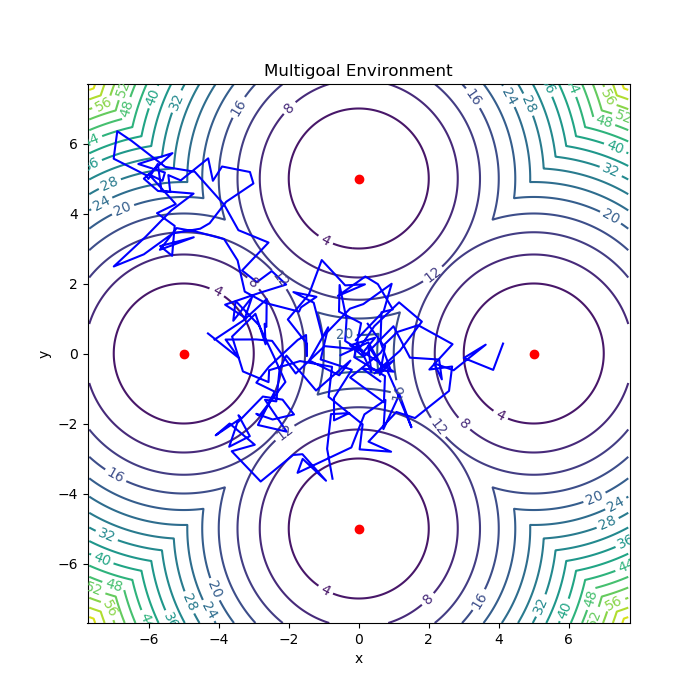

Average Reward across 4 episodes is -1849.76
Reward per step of the particle is -34.27


In [4]:
agent = lambda env: RandomAgent(env.action_space)
total_rewards = test_policy(agent)
print ('Average Reward across {:d} episodes is {:.2f}'.format(total_rewards[0].shape[0], np.mean(total_rewards[0])))
print ('Reward per step of the particle is {:.2f}'.format(np.mean(total_rewards[1])))

# Policy Gradient 

In [5]:
hid = 10
num_layers = 2
gamma = 0.9
num_epochs = 100
cpu = 2

MAX_STEPS_PER_EPISODE = 100
steps = MAX_STEPS_PER_EPISODE
seed = 37

In [6]:
from spinup.utils.run_utils import setup_logger_kwargs
logger_kwargs = setup_logger_kwargs('vpg', seed, data_dir='model/')
from custom_actor_critic import MLPActorCritic
from vpg import vpg as vpg_pytorch

In [7]:
epoch_reward = vpg_pytorch(lambda : gym.make(env_id), actor_critic=MLPActorCritic,
                            ac_kwargs=dict(hidden_sizes=[hid]*num_layers), gamma=gamma, 
                            seed=seed, steps_per_epoch=steps, epochs=num_epochs,
                            logger_kwargs=logger_kwargs, max_ep_len=MAX_STEPS_PER_EPISODE)

Logging data to model/vpg/vpg_s37/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            10,
            10
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "env_fn":	"<function <lambda> at 0x7f12dc543680>",
    "epochs":	100,
    "exp_name":	"vpg",
    "gamma":	0.9,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f12dc531850>":	{
            "epoch_dict":	{},
            "exp_name":	"vpg",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"model/vpg/vpg_s37",
            "output_file":	{
                "<_io.TextIOWrapper name='model/vpg/vpg_s37/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
        "exp_name":	"vpg",
        "output_dir":	"model/vpg/vpg_s37"
    },
    "max_ep_len":	100,
    "pi_lr":	0.0003,
    "save_freq":	10,
  

/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              10 |
|      AverageEpRet |       -1.12e+03 |
|          StdEpRet |             913 |
|          MaxEpRet |            -382 |
|          MinEpRet |       -3.37e+03 |
|             EpLen |              37 |
|      AverageVVals |           -6.81 |
|          StdVVals |            3.89 |
|          MaxVVals |            2.31 |
|          MinVVals |           -12.6 |
| TotalEnvInteracts |         1.1e+03 |
|            LossPi |         -0.0757 |
|             LossV |        6.81e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -735 |
|           Entropy |           0.919 |
|                KL |       -2.62e-09 |
|              Time |            5.19 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              20 |
|      AverageEpRet |       -1.15e+03 |
|          StdEpRet |        1.06e+03 |
|          MaxEpRet |            -190 |
|          MinEpRet |       -3.31e+03 |
|             EpLen |            39.9 |
|      AverageVVals |           -17.5 |
|          StdVVals |            2.48 |
|          MaxVVals |           -13.5 |
|          MinVVals |           -21.5 |
| TotalEnvInteracts |         2.1e+03 |
|            LossPi |          -0.161 |
|             LossV |         5.6e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -386 |
|           Entropy |           0.917 |
|                KL |       -3.34e-09 |
|              Time |            10.5 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              30 |
|      AverageEpRet |       -1.28e+03 |
|          StdEpRet |             932 |
|          MaxEpRet |            -352 |
|          MinEpRet |       -3.49e+03 |
|             EpLen |            43.2 |
|      AverageVVals |           -25.8 |
|          StdVVals |            2.82 |
|          MaxVVals |           -7.48 |
|          MinVVals |           -29.7 |
| TotalEnvInteracts |         3.1e+03 |
|            LossPi |          -0.212 |
|             LossV |        5.75e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -487 |
|           Entropy |           0.916 |
|                KL |       -2.03e-09 |
|              Time |            15.4 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              40 |
|      AverageEpRet |            -945 |
|          StdEpRet |             692 |
|          MaxEpRet |            -211 |
|          MinEpRet |       -3.24e+03 |
|             EpLen |            31.6 |
|      AverageVVals |           -34.2 |
|          StdVVals |            2.24 |
|          MaxVVals |           -30.8 |
|          MinVVals |           -37.7 |
| TotalEnvInteracts |         4.1e+03 |
|            LossPi |          -0.134 |
|             LossV |        4.66e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -315 |
|           Entropy |           0.913 |
|                KL |        1.31e-09 |
|              Time |            19.9 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              50 |
|      AverageEpRet |            -898 |
|          StdEpRet |             696 |
|          MaxEpRet |            -173 |
|          MinEpRet |       -3.03e+03 |
|             EpLen |            31.5 |
|      AverageVVals |             -42 |
|          StdVVals |            2.09 |
|          MaxVVals |           -38.8 |
|          MinVVals |           -45.6 |
| TotalEnvInteracts |         5.1e+03 |
|            LossPi |          -0.191 |
|             LossV |        3.86e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -270 |
|           Entropy |           0.911 |
|                KL |       -5.96e-10 |
|              Time |            24.5 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              60 |
|      AverageEpRet |       -1.28e+03 |
|          StdEpRet |        1.02e+03 |
|          MaxEpRet |            -351 |
|          MinEpRet |       -3.86e+03 |
|             EpLen |              43 |
|      AverageVVals |             -50 |
|          StdVVals |            2.25 |
|          MaxVVals |           -46.4 |
|          MinVVals |           -53.7 |
| TotalEnvInteracts |         6.1e+03 |
|            LossPi |          -0.182 |
|             LossV |        4.33e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -332 |
|           Entropy |           0.909 |
|                KL |        1.85e-09 |
|              Time |              29 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              70 |
|      AverageEpRet |            -973 |
|          StdEpRet |             791 |
|          MaxEpRet |            -175 |
|          MinEpRet |       -2.85e+03 |
|             EpLen |            34.7 |
|      AverageVVals |           -58.4 |
|          StdVVals |            2.18 |
|          MaxVVals |             -55 |
|          MinVVals |           -61.8 |
| TotalEnvInteracts |         7.1e+03 |
|            LossPi |          -0.156 |
|             LossV |        3.17e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -244 |
|           Entropy |           0.906 |
|                KL |       -3.16e-09 |
|              Time |            33.7 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              80 |
|      AverageEpRet |            -763 |
|          StdEpRet |             463 |
|          MaxEpRet |            -303 |
|          MinEpRet |       -1.78e+03 |
|             EpLen |            27.9 |
|      AverageVVals |           -66.1 |
|          StdVVals |             2.3 |
|          MaxVVals |           -62.6 |
|          MinVVals |           -69.7 |
| TotalEnvInteracts |         8.1e+03 |
|            LossPi |          -0.136 |
|             LossV |        3.34e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -268 |
|           Entropy |           0.904 |
|                KL |       -1.19e-10 |
|              Time |            38.4 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              90 |
|      AverageEpRet |       -1.11e+03 |
|          StdEpRet |             789 |
|          MaxEpRet |            -302 |
|          MinEpRet |       -3.67e+03 |
|             EpLen |              39 |
|      AverageVVals |           -74.2 |
|          StdVVals |            2.12 |
|          MaxVVals |           -70.8 |
|          MinVVals |           -77.6 |
| TotalEnvInteracts |         9.1e+03 |
|            LossPi |         -0.0898 |
|             LossV |        2.88e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -228 |
|           Entropy |           0.902 |
|                KL |        1.19e-10 |
|              Time |              43 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<IPython.core.display.Javascript object>


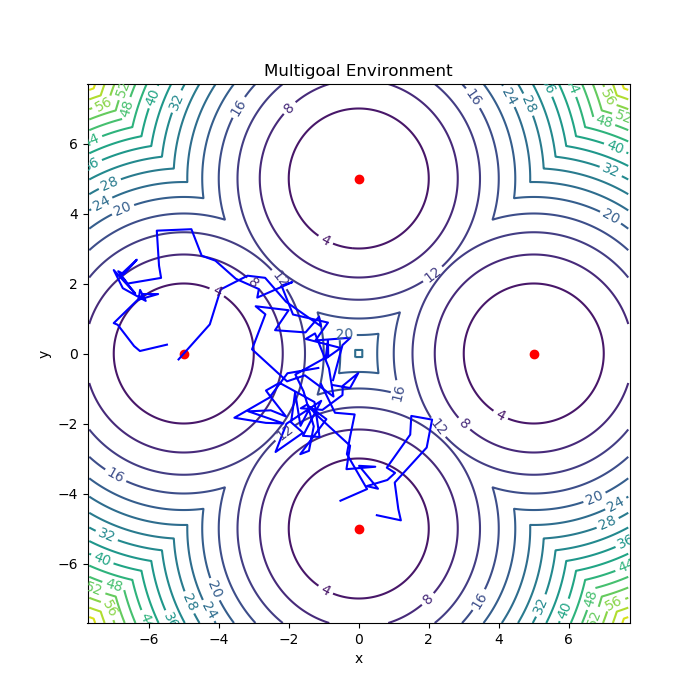

Average Reward across 4 episodes is -846.91
Reward per step of the particle is -27.30


In [10]:
agent = lambda env: torch.load('/host/final_project/model/vpg/vpg_s37/pyt_save/model.pt')
total_rewards = test_policy(agent)
print ('Average Reward across {:d} episodes is {:.2f}'.format(total_rewards[0].shape[0], np.mean(total_rewards[0])))
print ('Reward per step of the particle is {:.2f}'.format(np.mean(total_rewards[1])))

# Bayes Explore